## AutoML pipeline notebook
Created by Nikolay Pavlychev \
email: nikolaypavlychev@ya.ru

In [2]:
# Standard python libraries
import os

# Installed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

import joblib

from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


/home/nikolaypavlychev/anaconda3/envs/drugs_ner_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


/home/nikolaypavlychev/anaconda3/envs/drugs_ner_env/lib/python3.8/site-packages/lightautoml/transformers/text.py:22: UserWarning: 'gensim' - package isn't installed
  warnings.warn("'gensim' - package isn't installed")


In [3]:
sales_train =pd.read_csv('./data/train.csv',sep=',')
sales_test =pd.read_csv('./data/test.csv',sep=',')

sales_train.dtypes

ID                    object
item_category_id       int64
date_block_num         int64
item_price_sum       float64
item_price_mean      float64
item_cnt_day_sum     float64
item_cnt_day_mean    float64
target               float64
dtype: object

In [4]:
sales_train['item_category_id'] = sales_train['item_category_id'].astype(str)
sales_test['item_category_id'] = sales_test['item_category_id'].astype(str)
sales_train['date_block_num'] = sales_train['date_block_num'].astype(str)
sales_test['date_block_num'] = sales_test['date_block_num'].astype(str)

### AutoML params

In [ ]:
N_THREADS = 24
N_FOLDS = 4
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 3600
TARGET_NAME = 'target'

### AutoML training and evaluation

In [ ]:
task = Task("reg", greater_is_better=False, metric="mse", loss="mse",)

roles = {
    'target': TARGET_NAME,
    'drop': ['ID'],
    'numeric':['item_price_sum', 'item_price_mean', 'item_cnt_day_sum', 'item_cnt_day_mean'],
    'category':['item_category_id', 'date_block_num']
}

automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

In [ ]:
%%time 
out_of_fold_predictions = automl.fit_predict(sales_train, roles = roles, verbose = 1)

[05:37:28] Stdout logging level is INFO.
[05:37:28] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[05:37:28] Task: reg

[05:37:28] Start automl preset with listed constraints:
[05:37:28] - time: 3600.00 seconds
[05:37:28] - CPU: 24 cores
[05:37:28] - memory: 16 GB

[05:37:28] Train data shape: (562814, 8)

[05:37:37] Layer 1 train process start. Time left 3590.86 secs
[05:37:41] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[05:38:04] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -43.634176877300526
[05:38:04] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[05:38:04] Time left 3563.77 secs

[05:38:08] Selector_LightGBM fitting and predicting completed
[05:38:11] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[05:38:23] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -34.21963875694941
[05:38:23] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[05:38:23] Start hyperparameters optimization for Lv

In [ ]:
%%time

test_predictions = automl.predict(sales_test)
print(f'Prediction for test_data:\n{test_predictions}\nShape = {test_predictions.shape}')

Prediction for test_data:
array([[ 1.2744274],
       [ 1.8708632],
       [14.375582 ],
       ...,
       [ 1.3824899],
       [ 1.3824899],
       [ 1.3455229]], dtype=float32)
Shape = (113924, 1)
CPU times: user 22.7 s, sys: 91.1 ms, total: 22.8 s
Wall time: 1.42 s


In [ ]:
print(f'OOF score: {sqrt(mean_squared_error(sales_train[TARGET_NAME].values, out_of_fold_predictions.data[:, 0]))}')
print(f'HOLDOUT score: {sqrt(mean_squared_error(sales_test[TARGET_NAME].values, test_predictions.data[:, 0]))}')

OOF score: 5.757023926369013
HOLDOUT score: 11.651347913725791


In [ ]:
joblib.dump(automl,'automl_best.pkl')

['automl_best.pkl']

In [ ]:
%%time

print(automl.create_model_str_desc())

RD = ReportDeco(output_path = 'tabularAutoML_model_report')

automl_rd = RD(
    TabularAutoML(
        task = task, 
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    )
)

out_of_fold_predictions = automl_rd.fit_predict(sales_train, roles = roles, verbose = 1)

Final prediction for new objects (level 0) = 
	 0.94397 * (4 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.05603 * (4 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 
[19:16:27] Stdout logging level is INFO.
[19:16:27] Task: reg

[19:16:27] Start automl preset with listed constraints:
[19:16:27] - time: 3600.00 seconds
[19:16:27] - CPU: 10 cores
[19:16:27] - memory: 16 GB

[19:16:27] Train data shape: (562814, 8)



[19:16:30] Layer 1 train process start. Time left 3596.60 secs
[19:16:32] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[19:16:47] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -43.63457683725928
[19:16:47] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[19:16:47] Time left 3579.36 secs

[19:16:50] Selector_LightGBM fitting and predicting completed
[19:16:51] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[19:16:59] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -34.21963875694941
[19:16:59] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[19:16:59] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
[19:21:11] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[19:21:11] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[19:21:27] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -33.06256633456075
[19:21:27] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and p

CPU times: user 28.3 ms, sys: 19.2 ms, total: 47.5 ms
Wall time: 36 ms


<Axes: xlabel='Feature'>

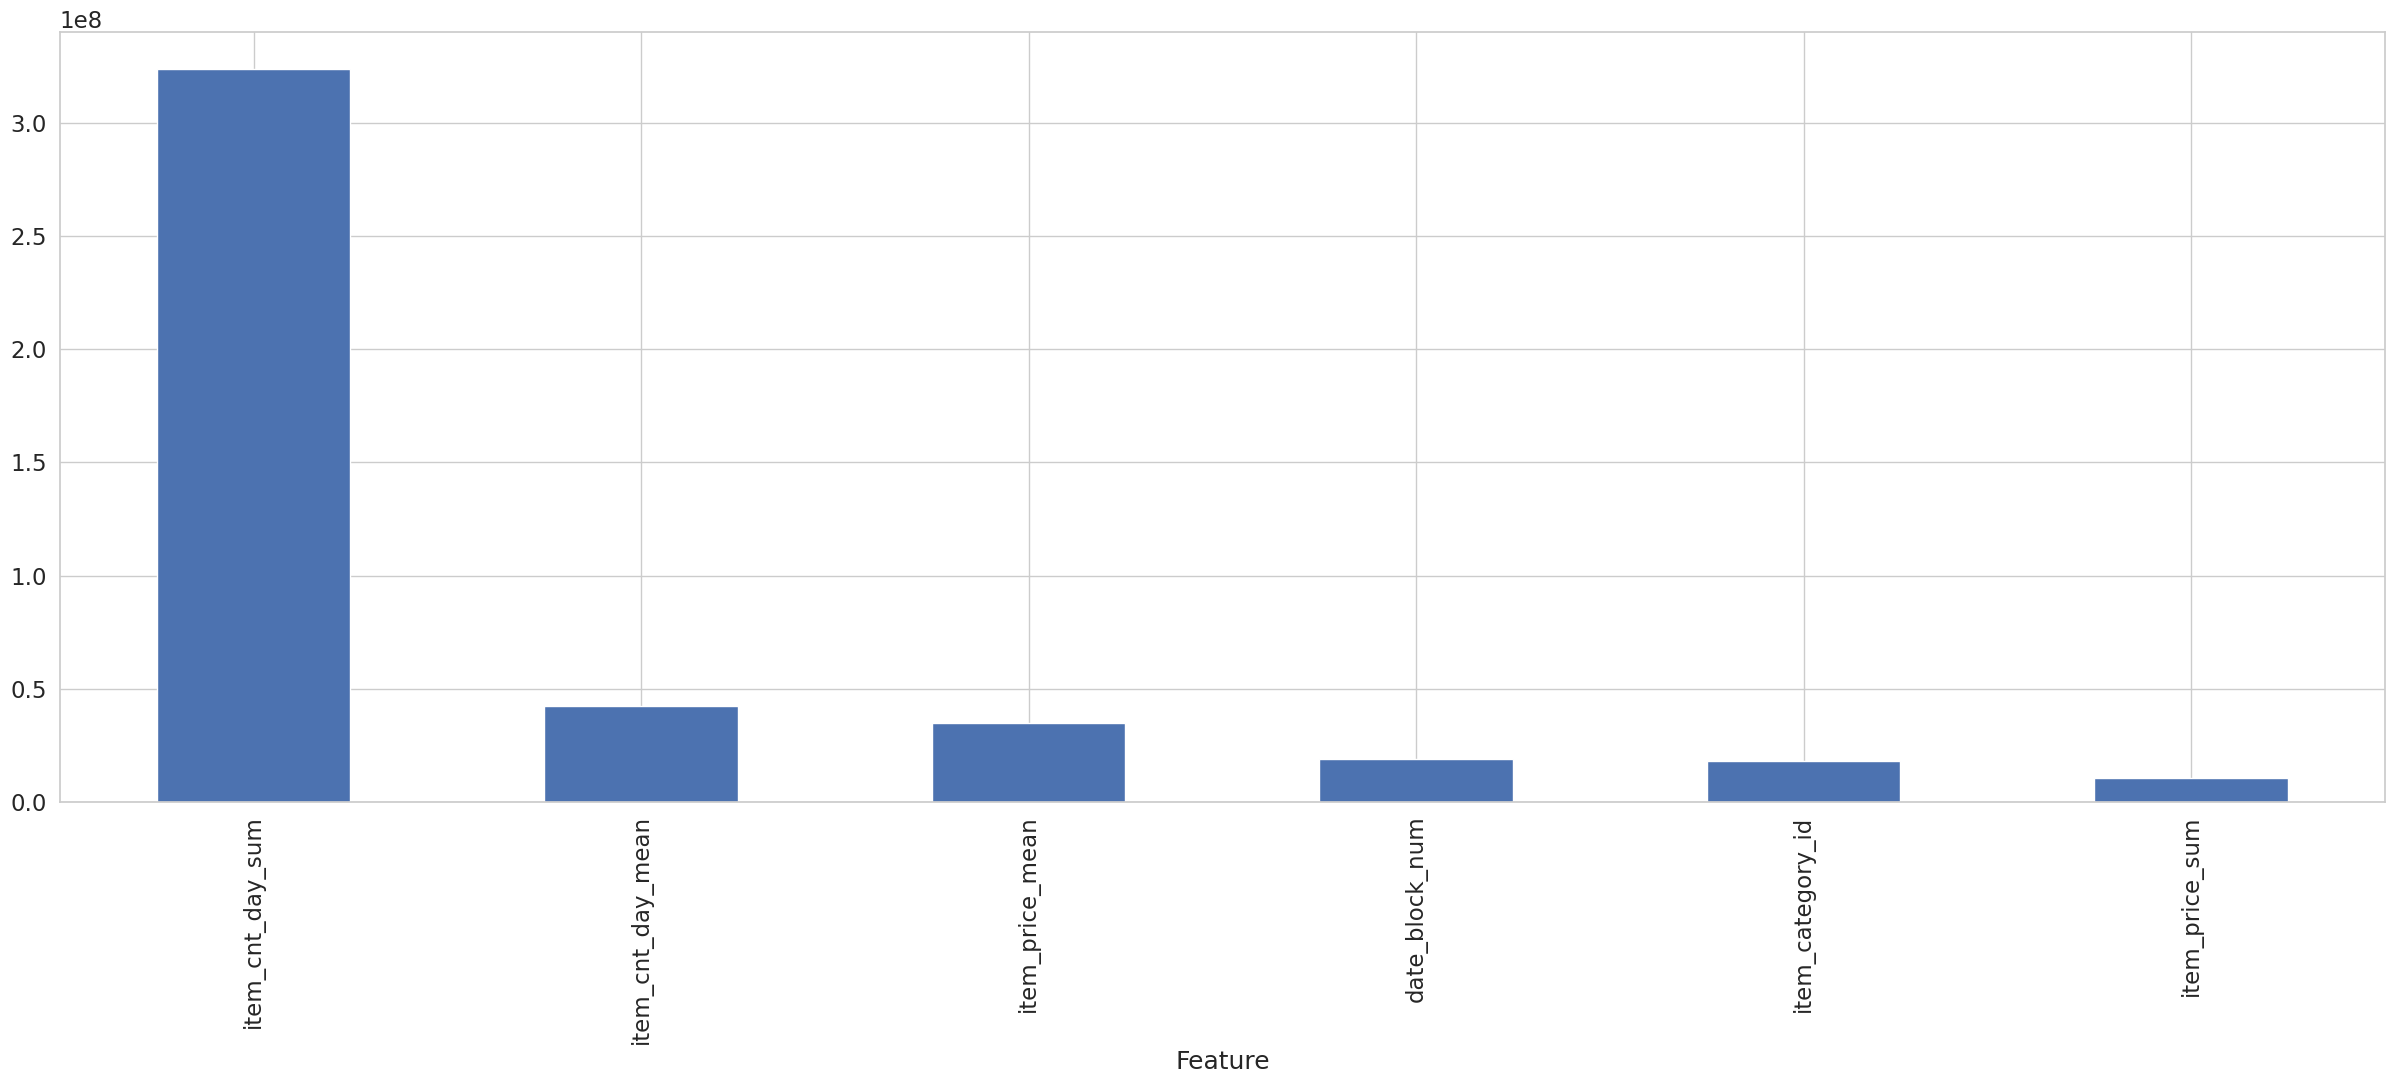

In [ ]:
%%time

fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)